In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import scale
from sklearn import metrics
from lifelines import CoxPHFitter

import warnings
warnings.simplefilter('ignore')

seed = 1029

In [172]:
df = pd.read_csv('data/ModelingData/covid_dataset_final_3_6_24.csv')
df = df.drop(['Unnamed: 0','Year','year', 'state','cases'],axis=1)

In [208]:
## Let's one-hot encode the region
df_modeling = pd.get_dummies(df, columns=['region'], prefix='region')
df_modeling.columns
df_modeling['num_months'] = df_modeling['num_months']+1

# Feature Selection

In [209]:
# # check correlation of each potential feature with our response variable
corr = df_modeling.corr().round(2).sort_values(by='death_event', ascending=False)

# corr_top_n = list(corr['death_event'][0:8].index)

# corr['death_event']

import pandas as pd
from tabulate import tabulate

# Assuming corr is your correlation dataframe

# Display the correlation table for all features
table = tabulate(corr[['death_event']][1:20], headers='keys', tablefmt='pretty', showindex=True)

# print(f"\nCorrelation Table:\n{table}\n")


corr_features = list(corr['death_event'][1:11].index)
corr_features

['doses_administered_cumulative',
 'num_months',
 'doses_distributed_cumulative',
 'V2A_Vaccine Availability (summary)',
 'V1_Vaccine Prioritisation (summary)',
 'region_Northeast',
 'H7_Vaccination policy',
 '85+ years',
 '80-84 years',
 '75-79 years']

In [260]:
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
X = df_modeling.loc[:, ~df_modeling.columns.isin(['death_event'])]
y = df_modeling['death_event']
# define the method
rfe_method = RFE(
    RandomForestClassifier(n_estimators=12, random_state=10),
    n_features_to_select=10,
    step=2,
)
rfe_method.fit(X, y)

selected_features = X.columns[(rfe_method.get_support())]

# Creating a table with the selected features
table = [["Selected Features"],
         ["-" * 20]]

for feature in selected_features:
    table.append([feature])

# Displaying the table
print(tabulate(table, headers="firstrow", tablefmt="grid"))

+----------------------+
| Selected Features    |
+======================+
| -------------------- |
+----------------------+
| 0-4 years            |
+----------------------+
| 10-14 years          |
+----------------------+
| 25-29 years          |
+----------------------+
| 30-34 years          |
+----------------------+
| 45-49 years          |
+----------------------+
| 5-9 years            |
+----------------------+
| 50-54 years          |
+----------------------+
| 55-59 years          |
+----------------------+
| 70-74 years          |
+----------------------+
| 75-79 years          |
+----------------------+


In [261]:
selected_features

Index(['0-4 years', '10-14 years', '25-29 years', '30-34 years', '45-49 years',
       '5-9 years', '50-54 years', '55-59 years', '70-74 years',
       '75-79 years'],
      dtype='object')

# Modeling

## Logistic Regression

In [216]:
df_modeling['region_Northeast'] = df_modeling['region_Northeast'].astype(int)


In [340]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import chi2

from sklearn.preprocessing import StandardScaler

model = LogisticRegression(fit_intercept=True, max_iter=1000)


X = df_modeling[corr_features]  # Use features selected by RFE
y = df_modeling['death_event']


# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1029)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df  = pd.DataFrame(X_test_scaled, columns=X_test.columns)


# Fit the logistic regression model using statsmodels and sklearn
model = LogisticRegression(random_state=0).fit(X_train_scaled, y_train)
#  Get coefficients
coefficients = model.coef_[0]

# Calculate odds ratios (interpretation)
interpretation = np.exp(coefficients)

# Display the interpretation
print("Interpretation of Coefficients:")
for i in range(len(interpretation)):
    print(f"   - The odds of death_event increase by a factor of {round(interpretation[i], 4)} "
          f"for each unit increase in {X_train.columns[i]}")
    
    
# # Create a table
# table_data = []
# for i in range(len(interpretation)):
#     table_data.append([X_train.columns[i], coefficients[i], np.exp(coefficients[i])])

# # Display the interpretation table
# table_headers = ["Feature", "Coefficient", "Odds Ratio"]
# print(tabulate(table_data, headers=table_headers, tablefmt="pretty"))

# Create a DataFrame
coefficients_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": coefficients,
    "Odds Ratio": interpretation
})

# Display the DataFrame
coefficients_df

(1000, 10) (1000,)
(250, 10) (250,)
Interpretation of Coefficients:
   - The odds of death_event increase by a factor of 0.3716 for each unit increase in doses_administered_cumulative
   - The odds of death_event increase by a factor of 1.5991 for each unit increase in num_months
   - The odds of death_event increase by a factor of 3.4448 for each unit increase in doses_distributed_cumulative
   - The odds of death_event increase by a factor of 1.2181 for each unit increase in V2A_Vaccine Availability (summary)
   - The odds of death_event increase by a factor of 1.6003 for each unit increase in V1_Vaccine Prioritisation (summary)
   - The odds of death_event increase by a factor of 1.4697 for each unit increase in region_Northeast
   - The odds of death_event increase by a factor of 1.2735 for each unit increase in H7_Vaccination policy
   - The odds of death_event increase by a factor of 2.4478 for each unit increase in 85+ years
   - The odds of death_event increase by a factor of 1

,Feature,Coefficient,Odds Ratio
0,doses_administered_cumulative,-0.989984,0.371583
1,num_months,0.469462,1.599133
2,doses_distributed_cumulative,1.236876,3.444834
3,V2A_Vaccine Availability (summary),0.197311,1.218123
4,V1_Vaccine Prioritisation (summary),0.470216,1.600340
5,region_Northeast,0.385069,1.469715
6,H7_Vaccination policy,0.241765,1.273495
7,85+ years,0.895182,2.447782
8,80-84 years,0.291748,1.338765
9,75-79 years,-1.025651,0.358563


# Model Interpretation

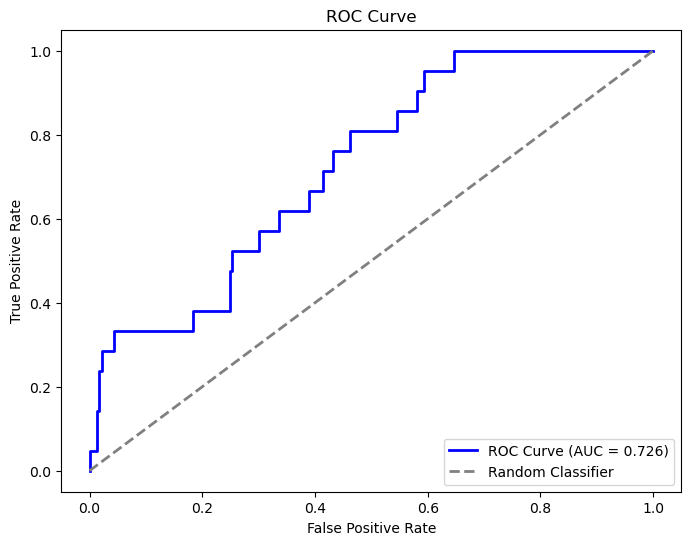

In [294]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

# Assuming you have already trained a logistic regression model and have 'test_data'
# X_test should contain the features, and y_test should contain the actual outcomes

# Make predictions on the test set
predicted_probs = model.predict_proba(X_test_scaled)[:, 1]

# Create a DataFrame with actual outcomes and predicted probabilities
prediction_data = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Probability': predicted_probs
})

# ROC curve
fpr, tpr, thresholds = roc_curve(prediction_data['Actual'], prediction_data['Predicted_Probability'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [326]:
y_pred = model.predict(X_test_scaled)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Compute precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

# Compute recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

Accuracy: 0.92
Precision: 0.50
Recall: 0.05


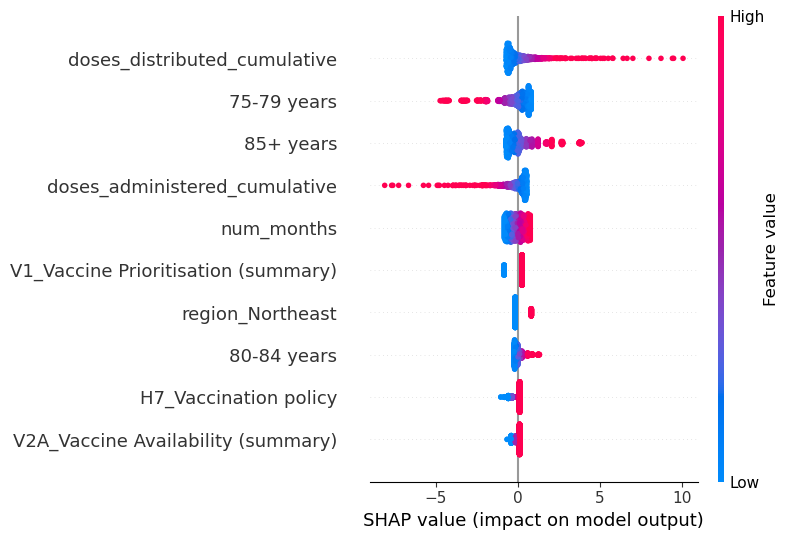

In [335]:
import shap
import math
shap.initjs()

sample_X = X_train_scaled_df.head(1000)
explainer = shap.LinearExplainer(model, sample_X, check_additivity=False)
# Calculate Shap values
shap_values = explainer.shap_values(sample_X)
# plot it
shap.summary_plot(shap_values, sample_X)


In [333]:
index_of_1 = None
count = 0
for idx,val in y_test.items():
    if val == 1:
        index_of_1 = count
        break 
        
    count += 1
print(index_of_1)

sample_instance = X_test_scaled_df.iloc[index_of_1]

shap_values_sample = explainer.shap_values(sample_instance)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_sample, sample_instance)

5
